In [1]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import nltk
import textstat
#nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import re
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textstat.textstat import textstat
from matplotlib.table import Table
from scipy.stats import multivariate_normal, invwishart
from abc import ABC, abstractmethod
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

In [4]:
df = pd.read_csv('main_dataset.csv')
test_df = pd.read_csv('exp_test.csv')

In [5]:
df

,index,author,text,ai_label
0,1,John Nery,The success of the Marcos-Duterte electoral al...,0
1,2,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0
2,3,John Nery,One of many lessons from the ongoing Twitter f...,0
3,4,John Nery,Of course we all need to be particular about t...,0
4,5,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0
...,...,...,...,...
95,96,Copilot,The concept of federalism has been a recurring...,1
96,97,Copilot,Election campaign finance transparency is a co...,1
97,98,Copilot,Mental health stigma remains a significant bar...,1
98,99,Copilot,Urban congestion and housing shortages are two...,1


In [6]:
#test_df

In [7]:
def preprocess_text(text):
    # Convert to lowercase
    return text.lower()

# Helper function to calculate complex sentence ratio
def count_clauses(sentence):
    # A simple approximation using commas, semicolons, and conjunctions
    return sentence.count(',') + sentence.count(';') + sentence.lower().count('and') + sentence.lower().count('but')

# Feature extraction function
def extract_features(text):
    # Tokenize words and sentences
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Basic metrics
    word_count = len([word for word in words if word.isalpha()])
    avg_word_length = np.mean([len(word) for word in words if word.isalpha()]) if word_count > 0 else 0
    avg_sentence_length = word_count / len(sentences) if len(sentences) > 0 else 0

    # Punctuation metrics
    punctuation_count = sum(1 for char in text if char in ['.', ',', ':', ';', '?', '!', '-', '\'', '\"'])
    punctuation_ratio = punctuation_count / word_count if word_count > 0 else 0
    avg_punctuation_per_sentence = punctuation_count / len(sentences) if len(sentences) > 0 else 0

    # Linguistic diversity features
    vocab_size = len(set([word for word in words if word.isalpha()]))
    vocab_ratio = vocab_size / word_count if word_count > 0 else 0

    # Readability metrics
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    gunning_fog = textstat.gunning_fog(text)
    smog_index = textstat.smog_index(text)
    cl_index = textstat.coleman_liau_index(text)

    # Sentence complexity metrics
    total_clauses = sum(count_clauses(sentence) for sentence in sentences)
    avg_clauses_per_sentence = total_clauses / len(sentences) if len(sentences) > 0 else 0
    complex_sentence_ratio = sum(1 for sentence in sentences if count_clauses(sentence) > 1) / len(sentences) if len(sentences) > 0 else 0

    # Lexical density
    pos_tags = pos_tag(words)
    content_words = [word for word, pos in pos_tags if pos.startswith(('NN', 'VB', 'JJ', 'RB'))]
    lexical_density = len(content_words) / word_count if word_count > 0 else 0

    return {
        'word_count': word_count,
        'sentence_count': len(sentences),
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_count': punctuation_count,
        'punctuation_ratio': punctuation_ratio,
        'avg_punctuation_per_sentence': avg_punctuation_per_sentence,
        'vocab_size': vocab_size,
        'vocab_ratio': vocab_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'coleman_liau_index': cl_index,
        'avg_clauses_per_sentence': avg_clauses_per_sentence,
        'complex_sentence_ratio': complex_sentence_ratio,
        'lexical_density': lexical_density
    }

# Apply preprocessing and feature extraction to each text sample
def preprocess_and_extract_features(df):
    df['preprocessed_text'] = df['text'].apply(preprocess_text)
    df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
    return pd.concat([df[['index', 'label']], df_features], axis=1)

In [8]:
#Apply preprocessing and feature extraction to each text sample
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df_features = df.apply(lambda row: extract_features(row['preprocessed_text']), axis=1).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)

In [21]:
# Define features (X) and target (y)
X = df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
y = df['author']

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Set up k-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Track metrics across folds
accuracies = []
classification_reports = []

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    # Split the dataset into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Collect classification report for the fold
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    
    # Print fold-specific metrics
    print(f"Fold {fold} Accuracy: {accuracy:.2f}")
    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_test, y_pred))

# Calculate overall metrics
mean_accuracy = np.mean(accuracies)
print(f"\nOverall Cross-Validation Accuracy: {mean_accuracy:.2f}")

C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Fold 1 Accuracy: 0.80
Fold 1 Classification Report:
                     precision    recall  f1-score   support

            Copilot       1.00      1.00      1.00         1
 Diwa C. Guinigundo       0.80      1.00      0.89         4
         GPT4o-mini       0.00      0.00      0.00         0
    Gemini1.5-flash       1.00      0.50      0.67         2
      Iris Gonzales       0.67      0.67      0.67         3
          John Nery       0.67      1.00      0.80         2
Jose Ma Montelibano       1.00      0.50      0.67         2
           Llama3.2       1.00      1.00      1.00         4
     Maria A. Ressa       0.00      0.00      0.00         1
      Phind Instant       1.00      1.00      1.00         1

           accuracy                           0.80        20
          macro avg       0.71      0.67      0.67        20
       weighted avg       0.83      0.80      0.79        20

Fold 2 Accuracy: 0.60
Fold 2 Classification Report:
                     precision    recal

C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold 3 Accuracy: 0.70
Fold 3 Classification Report:
                     precision    recall  f1-score   support

            Copilot       0.50      1.00      0.67         1
 Diwa C. Guinigundo       0.67      0.67      0.67         3
         GPT4o-mini       0.50      0.50      0.50         2
    Gemini1.5-flash       1.00      1.00      1.00         2
      Iris Gonzales       1.00      0.67      0.80         3
          John Nery       0.75      0.75      0.75         4
Jose Ma Montelibano       0.33      1.00      0.50         1
           Llama3.2       0.00      0.00      0.00         1
     Maria A. Ressa       1.00      0.67      0.80         3

           accuracy                           0.70        20
          macro avg       0.64      0.69      0.63        20
       weighted avg       0.74      0.70      0.70        20

Fold 4 Accuracy: 0.70
Fold 4 Classification Report:
                     precision    recall  f1-score   support

            Copilot       1.00      0.

C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\cotpl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [22]:
# Model Preparation
X_test = test_df.drop(['index', 'label'], axis=1)
y_test = test_df['label']

In [23]:
def classify_new_text(new_text, model):
    # Preprocess the text and extract features
    preprocessed_text = preprocess_text(new_text)
    new_features = extract_features(preprocessed_text)
    new_features_df = pd.DataFrame([new_features])

    # Reindex using the cleaned X_train's columns
    new_features_df = new_features_df.reindex(columns=X_train.columns)

    # Handle any NaN values
    new_features_df = new_features_df.fillna(0)

    # Predict the author
    predicted_author = model.predict(new_features_df)
    return predicted_author[0]

In [24]:
# Function to extract features and store them into a DataFrame
def extract_features_as_df(text):
    # Call the existing extract_features function
    raw_features = extract_features(text)
    
    # Convert the features to a DataFrame with two columns: Feature and Value
    features_df = pd.DataFrame(list(raw_features.items()), columns=['Feature', 'Value'])
    
    return features_df

def extract_features_for_csv(df):
    feature_dfs = df['text'].apply(extract_features_as_df)
    
    # Concatenate all the feature DataFrames into a single DataFrame
    all_features = pd.concat(feature_dfs.tolist(), ignore_index=True)
    
    # Concatenate the extracted features with the original DataFrame
    df_features = pd.concat([df, all_features], axis=1)
    
    # Remove rows with any NaN values
    df_features_cleaned = df_features.dropna()
    
    return df_features_cleaned

df_features = extract_features_for_csv(df)
df_features

,index,author,text,ai_label,preprocessed_text,word_count,sentence_count,avg_word_length,avg_sentence_length,punctuation_count,punctuation_ratio,avg_punctuation_per_sentence,vocab_size,vocab_ratio,flesch_reading_ease,gunning_fog,smog_index,coleman_liau_index,avg_clauses_per_sentence,complex_sentence_ratio,lexical_density,Feature,Value
0,1.0,John Nery,The success of the Marcos-Duterte electoral al...,0.0,the success of the marcos-duterte electoral al...,1558.0,65.0,4.835045,23.969231,179.0,0.114891,2.753846,610.0,0.391528,47.32,13.13,13.8,11.78,2.000000,0.523077,0.620668,word_count,1558.000000
1,2.0,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0.0,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,4.792542,26.339286,174.0,0.117966,3.107143,584.0,0.395932,54.66,13.13,13.4,11.09,2.589286,0.625000,0.608136,sentence_count,68.000000
2,3.0,John Nery,One of many lessons from the ongoing Twitter f...,0.0,one of many lessons from the ongoing twitter f...,851.0,39.0,4.659224,21.820513,117.0,0.137485,3.000000,386.0,0.453584,67.28,11.03,11.1,10.21,2.256410,0.487179,0.642773,avg_word_length,4.835045
3,4.0,John Nery,Of course we all need to be particular about t...,0.0,of course we all need to be particular about t...,996.0,40.0,4.618474,24.900000,109.0,0.109438,2.725000,390.0,0.391566,57.20,12.12,13.1,10.51,2.175000,0.600000,0.648594,avg_sentence_length,22.911765
4,5.0,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0.0,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,4.695000,24.657534,274.0,0.152222,3.753425,724.0,0.402222,59.53,11.04,11.8,10.68,2.808219,0.561644,0.655000,punctuation_count,179.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,Copilot,The concept of federalism has been a recurring...,1.0,the concept of federalism has been a recurring...,734.0,42.0,6.156676,17.476190,101.0,0.137602,2.404762,307.0,0.418256,19.37,13.24,16.2,18.62,1.833333,0.547619,0.656676,lexical_density,0.636925
96,97.0,Copilot,Election campaign finance transparency is a co...,1.0,election campaign finance transparency is a co...,756.0,41.0,6.203704,18.439024,112.0,0.148148,2.731707,317.0,0.419312,18.86,14.14,16.4,19.32,2.682927,0.609756,0.685185,word_count,1626.000000
97,98.0,Copilot,Mental health stigma remains a significant bar...,1.0,mental health stigma remains a significant bar...,712.0,41.0,5.869382,17.365854,100.0,0.140449,2.439024,311.0,0.436798,28.33,12.89,14.6,17.05,1.878049,0.512195,0.720506,sentence_count,71.000000
98,99.0,Copilot,Urban congestion and housing shortages are two...,1.0,urban congestion and housing shortages are two...,818.0,46.0,6.117359,17.782609,123.0,0.150367,2.673913,352.0,0.430318,19.16,13.81,16.0,18.74,2.021739,0.586957,0.753056,avg_word_length,4.699262


In [25]:
# Feature normalization ranges
feature_ranges = {
    'word_count': (0, 10000),  # Adjust as needed
    'sentence_count': (0, 1000),  # Adjust as needed
    'avg_word_length': (1, 10),  # Average word length typically ranges from 1 to 10 characters
    'avg_sentence_length': (0, 100),  # Average sentence length in words
    'punctuation_count': (0, 1000),  # Total punctuation marks, adjust as needed
    'punctuation_ratio': (0, 1),  # Ratio of punctuation marks per character
    'avg_punctuation_per_sentence': (0, 10),  # Adjust based on expected punctuation per sentence
    'vocab_size': (0, 1000),  # Vocabulary size, adjust as needed
    'vocab_ratio': (0, 1),  # Vocabulary ratio
    'flesch_reading_ease': (0, 100),  # Flesch reading ease score
    'gunning_fog': (6, 17),  # Gunning-Fog Index
    'smog_index': (6, 17),  # SMOG Index
    'coleman_liau_index': (5, 17),  # Coleman-Liau Index
    'avg_clauses_per_sentence': (0, 10),  # Average number of clauses per sentence
    'complex_sentence_ratio': (0, 1),  # Ratio of complex sentences
    'lexical_density': (0, 1)  # Lexical density
}

def normalize_feature(value, feature_name, feature_ranges):
    """Normalize a single feature value based on its predefined range."""
    if feature_name in feature_ranges:
        min_val, max_val = feature_ranges[feature_name]
        if max_val - min_val == 0:  # Avoid division by zero
            return 0
        return (value - min_val) / (max_val - min_val)
    else:
        raise ValueError(f"Feature '{feature_name}' does not have defined normalization ranges.")

def extract_and_normalize_features_as_df(text, feature_ranges):
    """Extract features, normalize them, and return as a DataFrame with normalized columns."""
    # Extract features into a DataFrame
    features_df = extract_features_as_df(text)

    # Check for empty or missing data
    if features_df.empty:
        print("No features extracted for the text. Returning an empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame for consistency

    # Create a dictionary to store normalized values
    normalized_data = {}

    for _, row in features_df.iterrows():
        feature_name = row['Feature']
        raw_value = row['Value']

        if feature_name in feature_ranges:
            # Normalize the feature value and add it as a new column
            normalized_data[f"{feature_name}_normalized"] = normalize_feature(raw_value, feature_name, feature_ranges)
        else:
            print(f"Feature '{feature_name}' not found in feature_ranges. Skipping normalization.")

    # Convert normalized data to a DataFrame
    normalized_df = pd.DataFrame([normalized_data])
    return normalized_df

def extract_and_normalize_features_for_csv(df, feature_ranges):
    """Extract and normalize features for the entire dataset."""
    # Initialize a list to store normalized DataFrames for each text
    normalized_dfs = []

    for text in df['text']:
        normalized_df = extract_and_normalize_features_as_df(text, feature_ranges)
        normalized_dfs.append(normalized_df)

    # Concatenate all normalized DataFrames into a single DataFrame
    all_normalized_features = pd.concat(normalized_dfs, ignore_index=True)

    # Add the normalized columns to the original DataFrame
    df_features = pd.concat([df.reset_index(drop=True), all_normalized_features.reset_index(drop=True)], axis=1)

    # Drop rows with NaN values if any normalized feature is missing
    df_features_cleaned = df_features.dropna()

    return df_features_cleaned

In [26]:
# Extract and normalize features for the dataset
df_normalized_features = extract_and_normalize_features_for_csv(df, feature_ranges)

# Display the normalized DataFrame
df_normalized_features

,index,author,text,ai_label,preprocessed_text,word_count,sentence_count,avg_word_length,avg_sentence_length,punctuation_count,punctuation_ratio,avg_punctuation_per_sentence,vocab_size,vocab_ratio,flesch_reading_ease,gunning_fog,smog_index,coleman_liau_index,avg_clauses_per_sentence,complex_sentence_ratio,lexical_density,word_count_normalized,sentence_count_normalized,avg_word_length_normalized,avg_sentence_length_normalized,punctuation_count_normalized,punctuation_ratio_normalized,avg_punctuation_per_sentence_normalized,vocab_size_normalized,vocab_ratio_normalized,flesch_reading_ease_normalized,gunning_fog_normalized,smog_index_normalized,coleman_liau_index_normalized,avg_clauses_per_sentence_normalized,complex_sentence_ratio_normalized,lexical_density_normalized
0,1,John Nery,The success of the Marcos-Duterte electoral al...,0,the success of the marcos-duterte electoral al...,1558.0,65.0,4.835045,23.969231,179.0,0.114891,2.753846,610.0,0.391528,47.32,13.13,13.8,11.78,2.000000,0.523077,0.620668,0.1558,0.068,0.426116,0.229118,0.179,0.114891,0.263235,0.644,0.413350,0.4732,0.648182,0.709091,0.565000,0.191176,0.529412,0.616816
1,2,John Nery,The war on Ninoy Aquino’s legacy is a fight th...,0,the war on ninoy aquino’s legacy is a fight th...,1475.0,56.0,4.792542,26.339286,174.0,0.117966,3.107143,584.0,0.395932,54.66,13.13,13.4,11.09,2.589286,0.625000,0.608136,0.1475,0.056,0.421394,0.263393,0.174,0.117966,0.310714,0.615,0.416949,0.5466,0.648182,0.672727,0.507500,0.258929,0.625000,0.604746
2,3,John Nery,One of many lessons from the ongoing Twitter f...,0,one of many lessons from the ongoing twitter f...,851.0,39.0,4.659224,21.820513,117.0,0.137485,3.000000,386.0,0.453584,67.28,11.03,11.1,10.21,2.256410,0.487179,0.642773,0.0851,0.040,0.406580,0.212750,0.117,0.137485,0.292500,0.409,0.480611,0.6728,0.457273,0.463636,0.434167,0.220000,0.475000,0.643948
3,4,John Nery,Of course we all need to be particular about t...,0,of course we all need to be particular about t...,996.0,40.0,4.618474,24.900000,109.0,0.109438,2.725000,390.0,0.391566,57.20,12.12,13.1,10.51,2.175000,0.600000,0.648594,0.0996,0.040,0.402053,0.249000,0.109,0.109438,0.272500,0.412,0.413655,0.5720,0.556364,0.645455,0.459167,0.217500,0.600000,0.649598
4,5,John Nery,"In 'Some People Need Killing,' the acclaimed j...",0,"in 'some people need killing,' the acclaimed j...",1800.0,73.0,4.695000,24.657534,274.0,0.152222,3.753425,724.0,0.402222,59.53,11.04,11.8,10.68,2.808219,0.561644,0.655000,0.1800,0.073,0.410556,0.246575,0.274,0.152222,0.375342,0.769,0.427222,0.5953,0.458182,0.527273,0.473333,0.280822,0.561644,0.653889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Copilot,The concept of federalism has been a recurring...,1,the concept of federalism has been a recurring...,734.0,42.0,6.156676,17.476190,101.0,0.137602,2.404762,307.0,0.418256,19.37,13.24,16.2,18.62,1.833333,0.547619,0.656676,0.0734,0.042,0.572964,0.174762,0.101,0.137602,0.240476,0.343,0.467302,0.1937,0.658182,0.927273,1.135000,0.183333,0.547619,0.656676
96,97,Copilot,Election campaign finance transparency is a co...,1,election campaign finance transparency is a co...,756.0,41.0,6.203704,18.439024,112.0,0.148148,2.731707,317.0,0.419312,18.86,14.14,16.4,19.32,2.682927,0.609756,0.685185,0.0756,0.041,0.578189,0.184390,0.112,0.148148,0.273171,0.363,0.480159,0.1886,0.740000,0.945455,1.193333,0.268293,0.609756,0.686508
97,98,Copilot,Mental health stigma remains a significant bar...,1,mental health stigma remains a significant bar...,712.0,41.0,5.869382,17.365854,100.0,0.140449,2.439024,311.0,0.436798,28.33,12.89,14.6,17.05,1.878049,0.512195,0.720506,0.0712,0.041,0.541042,0.173659,0.100,0.140449,0.243902,0.347,0.487360,0.2833,0.626364,0.781818,1.004167,0.187805,0.512195,0.720506
98,99,Copilot,Urban congestion and housing shortages are two...,1,urban congestion and housing shortages are two...,818.0,46.0,6.117359,17.

In [27]:
# Function to extract stylometric features for BOCPD
def extract_stylometric_features_for_bocpd(new_text):
    preprocessed_text = preprocess_text(new_text)
    features = extract_features(preprocessed_text)
    return features

In [28]:
# Hazard function
def constant_hazard(lam, t):
    return 1 / lam

# Predictive model (Gaussian)
class MultivariateGaussianPredictiveModel:
    def __init__(self, mu0, kappa0=1, alpha0=1, beta0=None):
        # mu0 is a vector for the mean of the prior
        # beta0 is a matrix for the covariance of the prior
        self.mu0 = np.array(mu0)
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0 if beta0 is not None else np.eye(len(mu0))  # Identity matrix if not provided
        
        # Initialize posterior parameters
        self.mu = np.array(mu0)
        self.kappa = kappa0
        self.alpha = alpha0
        self.beta = np.array(self.beta0)

    def update(self, x):
        x = np.array(x)
        self.kappa += 1
        self.mu = (self.kappa * self.mu0 + x) / (self.kappa + 1)
        diff = x - self.mu0
        self.beta += 0.5 * np.outer(diff, diff)  # Update covariance
        self.alpha += 0.5

    def log_predictive(self, x):
        d = len(self.mu0)  # Dimensionality
        x = np.array(x)

        # Covariance matrix for predictive distribution
        cov_matrix = (self.beta * (self.kappa + 1)) / (self.alpha * self.kappa)
    
        # Regularize the covariance matrix
        cov_matrix += np.eye(d) * 1e-6  # Add small value to diagonal

        try:
            cov_det = np.linalg.det(cov_matrix)
            cov_inv = np.linalg.inv(cov_matrix)

            # Multivariate Gaussian log probability
            log_prob = -0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(cov_det) - \
                       0.5 * np.dot((x - self.mu).T, np.dot(cov_inv, (x - self.mu)))
            return log_prob
        except np.linalg.LinAlgError:
            print("Covariance matrix is singular. Returning -inf for log probability.")
            return -np.inf  # Return a very low log probability

# Bayesian Online Change Point Detection algorithm
def bocpd(data, hazard_func, predictive_model):
    T = len(data)
    P = np.zeros((T+1, T+1))
    P[0, 0] = 1
    
    max_run_length = []
    
    for t in range(1, T+1):
        hazard = hazard_func(t)
        log_pred_prob = np.array([predictive_model.log_predictive(data[t-1]) for _ in range(t)])
        P[t, 1:t+1] = P[t-1, :t] * np.exp(log_pred_prob) * (1 - hazard)
        P[t, 0] = np.sum(P[t-1, :t] * hazard)
        P[t, :t+1] /= np.sum(P[t, :t+1])
        predictive_model.update(data[t-1])
        max_run_length.append(np.argmax(P[t, :t+1]))
    
    return P, max_run_length

# Detect change points
def detect_change_points(run_length_probs):
    change_points = []
    for t, prob in enumerate(run_length_probs):
        if prob == 0:  # Run length resets, indicating a change
            change_points.append(t)
    return change_points


In [29]:
def display_table_with_white_background(dataframe, title):
    # Round numeric values to 2 decimal places
    dataframe = dataframe.round(2)

    fig, ax = plt.subplots(figsize=(12, 4))  # Adjust size as needed
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # This will set the default font size for the table

    # Set column width and cell height
    col_width = 1.5
    row_height = 0.4
    num_rows, num_cols = dataframe.shape

    # Add table headers
    for i, column in enumerate(dataframe.columns):
        cell = table.add_cell(0, i, width=col_width, height=row_height, text=column, loc='center', facecolor='white', edgecolor='black')
        cell._text.set_fontsize(12)  # Set font size for header

    # Add table data
    for i, row in dataframe.iterrows():
        for j, value in enumerate(row):
            cell = table.add_cell(i + 1, j, width=col_width, height=row_height, text=f"{value:.2f}" if isinstance(value, (int, float)) else value, loc='center', facecolor='white', edgecolor='black')
            cell._text.set_fontsize(10)  # Set font size for data

    ax.add_table(table)
    plt.title(title, fontsize=14, pad=20)
    plt.show()

In [30]:
def detect_change_points_in_text(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features = extract_features(preprocess_text(new_text))
    
    features_df = pd.DataFrame([features])
    features_df = features_df[['word_count', 'avg_word_length', 'avg_sentence_length',
        'punctuation_ratio', 'avg_punctuation_per_sentence', 'vocab_size', 'vocab_ratio', 
        'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
        'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']]
    
    predicted_author = trained_model.predict(features_df)

    print(f"Provided Author: {author}")
    print(f"Predicted Author: {predicted_author}")
    
    if predicted_author[0] != author:
        print(f"Warning: The provided author does not match the predicted author. Using provided author '{author}' for analysis. Predicted author is: '{predicted_author}'")
    
    # Extract stylometric features for each sentence
    sentences = sent_tokenize(new_text)
    sentence_features = []
    
    for sentence in sentences:
        preprocessed_sentence = preprocess_text(sentence)
        sentence_feature = extract_features(preprocessed_sentence)
        
        selected_features = [
            sentence_feature['avg_word_length'], 
            sentence_feature['avg_sentence_length'], 
            sentence_feature['punctuation_ratio'], 
            sentence_feature['vocab_ratio'],
            sentence_feature['flesch_reading_ease'],
            sentence_feature['gunning_fog'],
            sentence_feature['smog_index'],
            sentence_feature['coleman_liau_index'],
            sentence_feature['avg_clauses_per_sentence'],
            sentence_feature['complex_sentence_ratio'],
            sentence_feature['lexical_density']
        ]
        sentence_features.append(selected_features)
    
    sentence_features = np.array(sentence_features)
    
    # Initialize BOCPD model for multivariate data
    hazard_func = lambda t: constant_hazard(250, t)
    initial_mean = np.mean(sentence_features, axis=0)
    initial_covariance = np.cov(sentence_features, rowvar=False)  # Initial covariance matrix
    
    predictive_model = MultivariateGaussianPredictiveModel(mu0=initial_mean, beta0=initial_covariance)
    
    # Run BOCPD on all selected features (multivariate analysis)
    P, max_run_length = bocpd(sentence_features, hazard_func, predictive_model)

    # Detect change points
    changepoints = detect_change_points(max_run_length)

    feature_categories = {
        'Phraseology': ['avg_word_length', 'avg_sentence_length', 'avg_clauses_per_sentence'],
        'Punctuation': ['punctuation_ratio'],
        'Linguistic Diversity': ['vocab_ratio', 'lexical_density', 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index', 'complex_sentence_ratio'],
        # 'readability': ['flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index'],
        # 'complexity': ['complex_sentence_ratio']
    }

    explanations = []
    changepoint_data = [] #List to collect data for DataFrame
    
    # Initialize counters for category changes
    category_changes = {category: set() for category in feature_categories.keys()}
    total_changes = {category: 0 for category in feature_categories.keys()}
    
    for idx in changepoints:
        if idx > 0 and idx < len(sentences):
            prev_features = sentence_features[idx - 1]
            curr_features = sentence_features[idx]
            
            feature_changes = []
            for i, feature_name in enumerate(
                ['avg_word_length', 'avg_sentence_length', 'punctuation_ratio', 'vocab_ratio',
                 'flesch_reading_ease', 'gunning_fog', 'smog_index', 'coleman_liau_index',
                 'avg_clauses_per_sentence', 'complex_sentence_ratio', 'lexical_density']):
                
                change = curr_features[i] - prev_features[i]
                
                # Only include positive changes
                if change > 0:  # Process only non-zero changes
                    category = next((cat for cat, features in feature_categories.items() if feature_name in features), None)
    
                    if category:
                        category_changes[category].add(idx)
    
                        # Normalize change and ensure non-negative value
                        normalized_change = max(normalize_feature(change, feature_name, feature_ranges), 0)
    
                        feature_changes.append({
                            'Feature': feature_name,
                            'Change Value': normalized_change,  # Always non-negative
                            'Category': category
                        })
                        
                        # Add row to changepoint data
                        changepoint_data.append({
                            'Sentence Index': idx,
                            'Sentence': sentences[idx],
                            'Feature': feature_name,
                            'Change Value': normalized_change,
                            'Category': category
                        })
       
           
            if feature_changes:  # Only add explanations if there are valid positive changes
                explanation = {
                    'sentence': sentences[idx],
                    'feature_changes': feature_changes
                }
                explanations.append(explanation)

    # Create DataFrame from collected changepoint data
    changepoint_df = pd.DataFrame(changepoint_data)
    if not changepoint_df.empty:  # Check if the DataFrame is non-empty
        average_changes = (
            changepoint_df.groupby('Category')['Change Value']
            .mean()
            .reset_index()
            .rename(columns={'Change Value': 'Average Change Value'})
        )
        
        print("\n--- Average Normalized Change Value by Category ---")
        print(average_changes)
    else:
        print("No change points detected; no averages to calculate.") 

    # Summarize the average changes across all categories
    overall_mean = average_changes['Average Change Value'].sum() / 3  # Divide the sum by 3 categories
    print(f"\nOverall Mean of Change Values Across Categories: {overall_mean:.4f}")

    # Determine if the text is AI-generated based on the threshold
    if overall_mean > 0.20:
        print("The text is likely AI-generated.")
    if overall_mean <= 0.20:
        print("The text is likely human-written.")
    else:
        print("No change points detected; no averages to calculate.")
    
    # Display summary of changes by category
    # print("\n--- Percentage of Change by Category ---")
    # total_sentences = len(sentences)
    # for category, sentence_indices in category_changes.items():
    #     unique_changes = len(sentence_indices)
    #     category_percentage = (unique_changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")
    print("\n")
    # Display results similarly
    for explanation in explanations:
        print(f"Change detected in sentence: {explanation['sentence']}")
        print("Feature changes:")
        
        table_data = []
        for feature_change in explanation['feature_changes']:
            table_data.append([
                feature_change['Feature'],
                feature_change['Change Value'],
                feature_change['Category']
            ])
        
        change_table = pd.DataFrame(table_data, columns=[
            'Feature', 'Change Value', 'Category'
        ])
        display_table_with_white_background(change_table, "Change Point Detection of Features for this Sentence")

    # print("\n--- Percentage of Change by Category ---")
    # for category, changes in category_changes.items():
    #     total_sentences = len(sentences)
    #     category_percentage = (changes / total_sentences) * 100 if total_sentences > 0 else 0
    #     print(f"{category.capitalize()}: {category_percentage:.2f}% change detected out of {total_sentences} sentences.")

    return changepoints, explanations, changepoint_df


In [31]:
def detect_change_points_in_text_with_normalization(new_text, author, trained_model):
    # Preprocess and extract features for the new text
    features_df = extract_features_as_df(preprocess_text(new_text))
    
    # Normalize the feature values
    normalized_features_df = normalize_features(features_df)
    
    print("Features with Normalized Values:")
    display(normalized_features_df)
    
    # Use normalized values in further computations
    normalized_features = normalized_features_df['Normalized Value'].values
    
    # Perform changepoint detection using normalized features
    # (Insert the existing BOCPD changepoint detection logic here)
    # Ensure all calculations use the normalized_features array

    return normalized_features_df


Provided Author: Copilot
Predicted Author: ['Copilot']

--- Average Normalized Change Value by Category ---
               Category  Average Change Value
0  Linguistic Diversity              0.282942
1           Phraseology              0.127873
2           Punctuation              0.106538

Overall Mean of Change Values Across Categories: 0.1725
The text is likely human-written.


Change detected in sentence: This editorial examines the causes, impacts, and potential solutions to plastic pollution in the Philippines.
Feature changes:


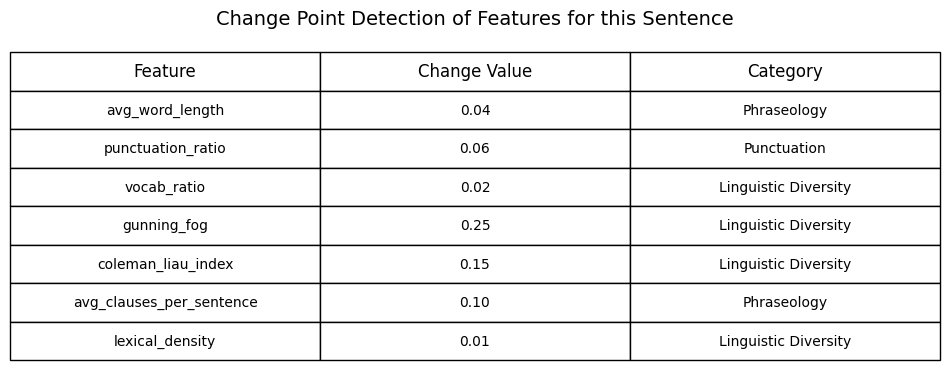

Change detected in sentence: The Scale of the Problem
The Philippines generates approximately 2.7 million metric tons of plastic waste annually, with a significant portion ending up in the ocean1.
Feature changes:


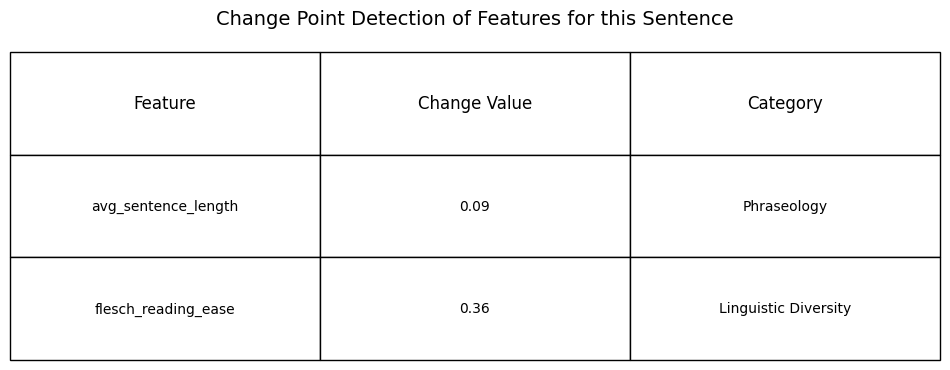

Change detected in sentence: This alarming statistic underscores the magnitude of the problem and the urgent need for effective interventions.
Feature changes:


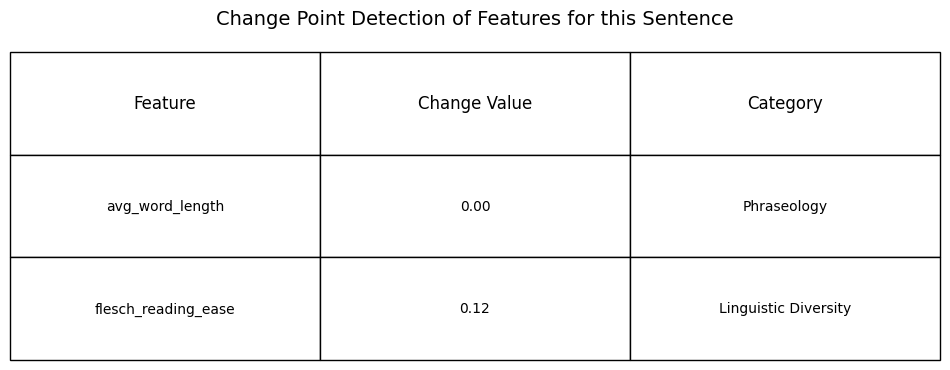

Change detected in sentence: Causes of Plastic Pollution
Several factors contribute to the severe plastic pollution problem in the Philippines:

Single-Use Plastics: The widespread use of single-use plastics, such as sachets, bags, and bottles, is a major contributor to plastic waste.
Feature changes:


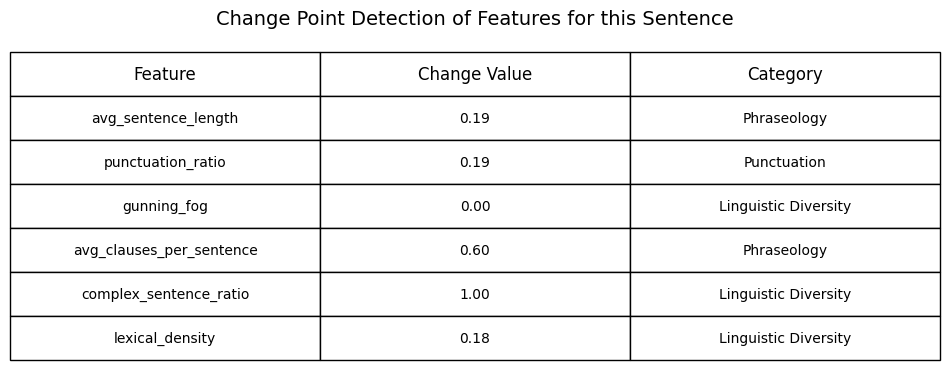

Change detected in sentence: These items are often discarded after a single use, leading to significant environmental pollution2.
Feature changes:


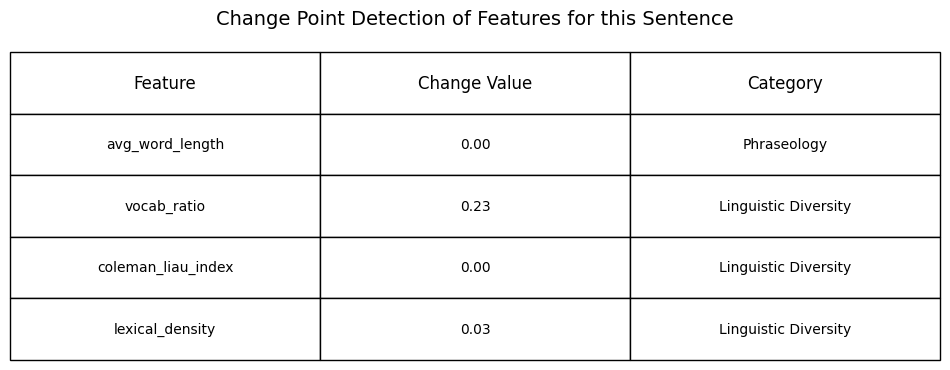

Change detected in sentence: Only about 33% of waste is properly managed, with the rest ending up in landfills, rivers, and oceans3.
Feature changes:


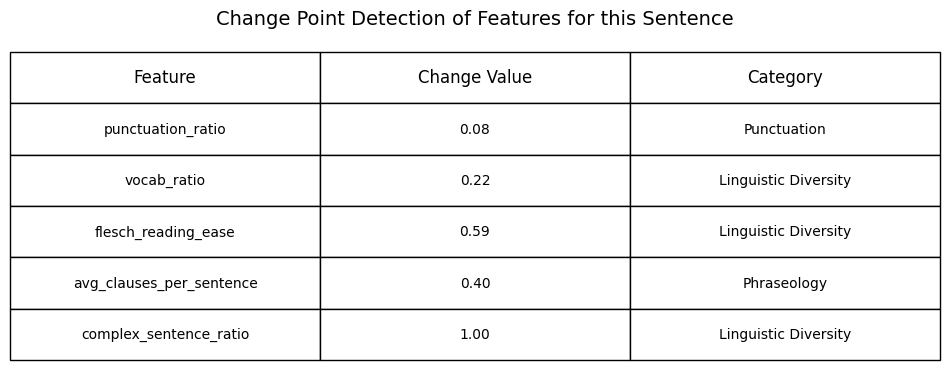

Change detected in sentence: The lack of sanitary landfills and proper waste disposal facilities exacerbates the problem4.
Feature changes:


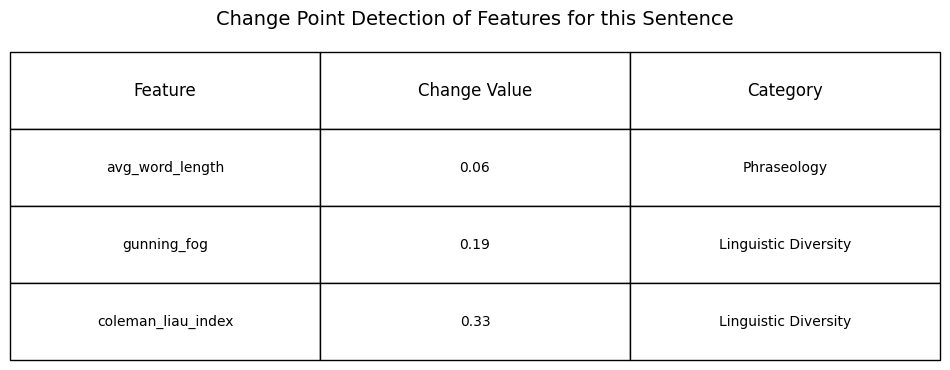

Change detected in sentence: Urban Runoff and Improper Disposal: Urban runoff and improper waste disposal practices contribute to the leakage of plastic waste into waterways.
Feature changes:


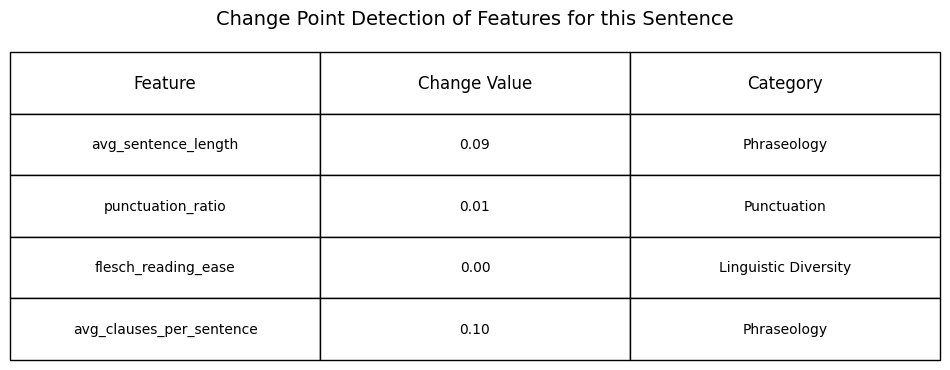

Change detected in sentence: In metropolitan areas like Manila, waste management systems are often overwhelmed, leading to significant plastic pollution3.
Feature changes:


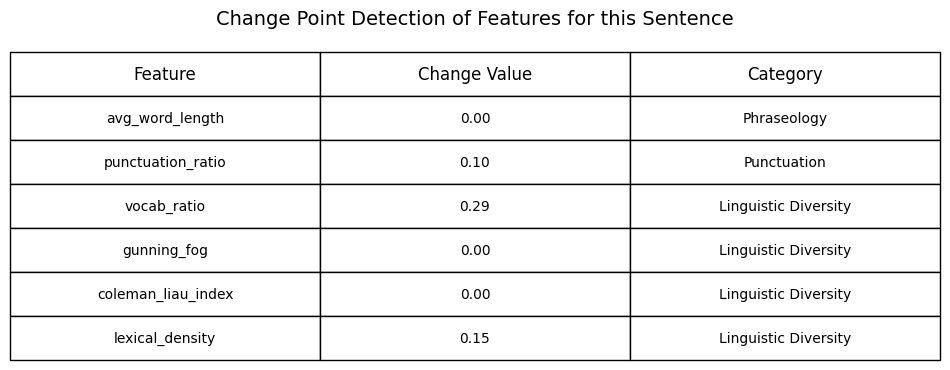

Change detected in sentence: Economic and Cultural Factors: The "tingi-tingi" culture, where products are sold in small, disposable packaging, is prevalent due to economic constraints.
Feature changes:


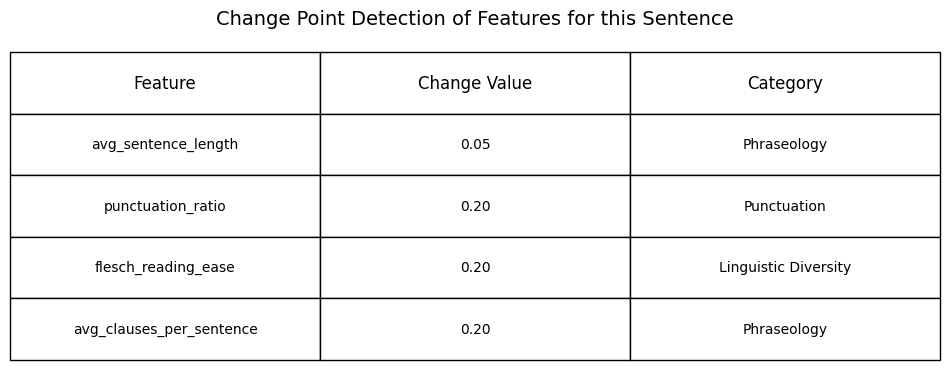

Change detected in sentence: This practice results in a high volume of plastic waste5.
Feature changes:


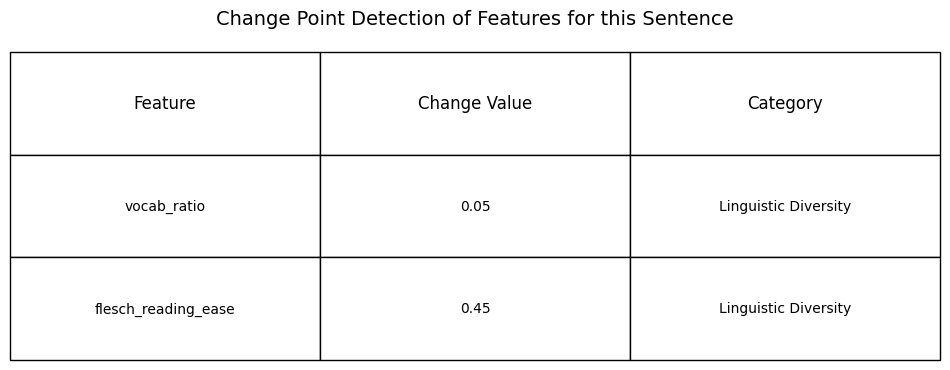

Change detected in sentence: Impacts of Plastic Pollution
The impacts of plastic pollution in the Philippines are far-reaching and multifaceted:

Environmental Damage: Plastic pollution poses a dire threat to marine ecosystems.
Feature changes:


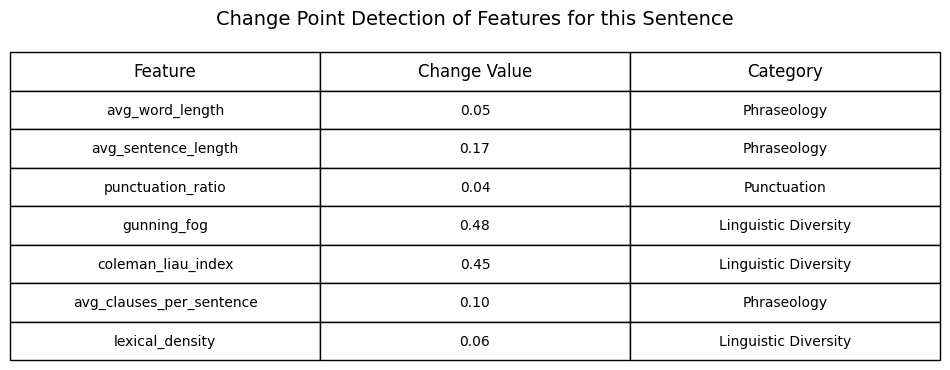

Change detected in sentence: Additionally, plastic waste damages coral reefs and mangrove forests, which are critical for coastal protection and marine biodiversity3.
Feature changes:


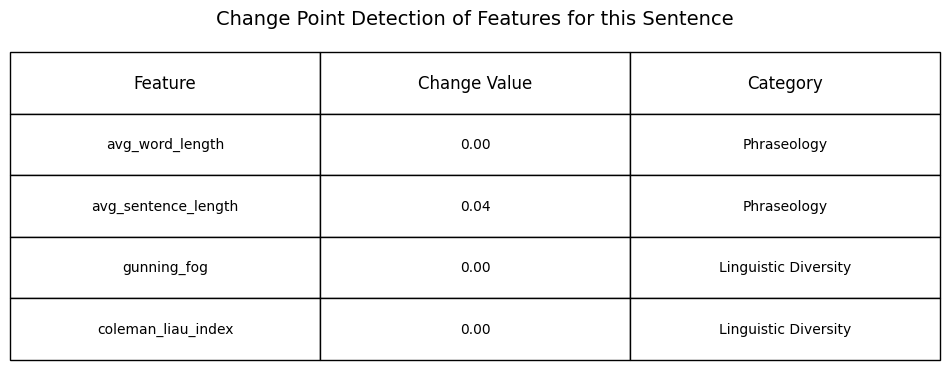

Change detected in sentence: Public Health Risks: The improper disposal of plastics can lead to the leaching of toxic chemicals into the soil and water, posing health risks to communities5.
Feature changes:


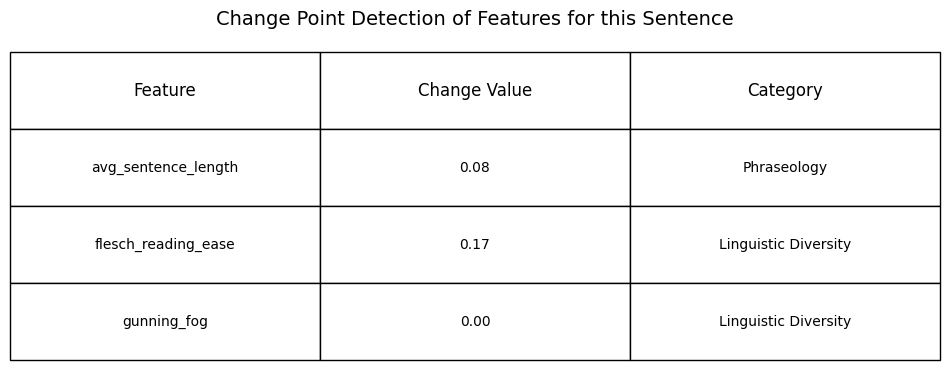

Change detected in sentence: These communities face economic and health challenges due to the presence of plastic waste in their environment3.
Feature changes:


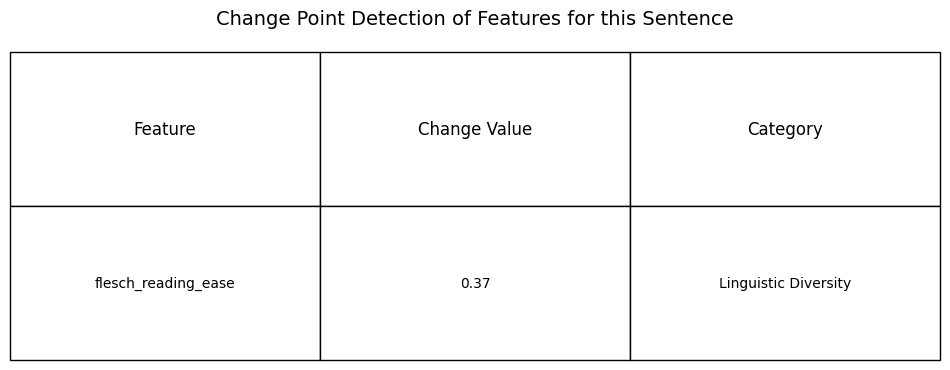

Change detected in sentence: Potential Solutions
Addressing plastic pollution in the Philippines requires a comprehensive and multi-faceted approach:

Policy Reforms: Strengthening regulations on single-use plastics and implementing incentives for businesses to adopt sustainable packaging alternatives are crucial steps.
Feature changes:


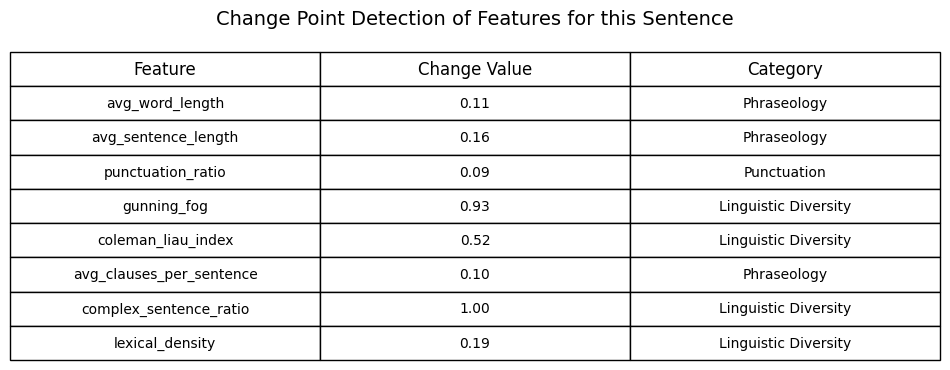

Change detected in sentence: Improving Waste Management: Enhancing waste management infrastructure is essential to reduce plastic pollution.
Feature changes:


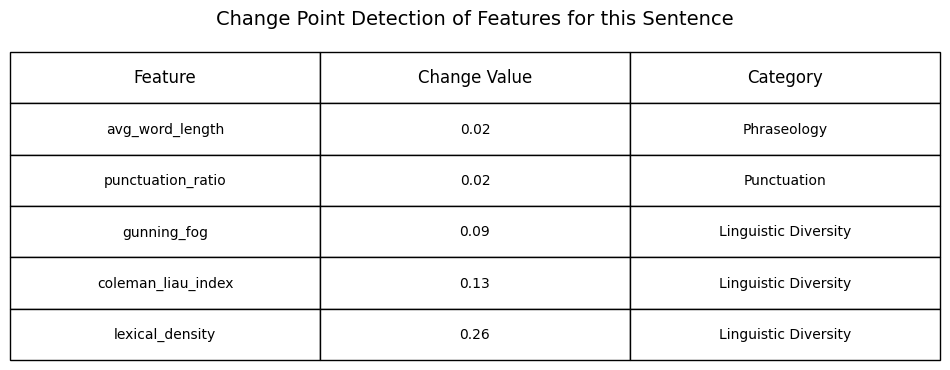

Change detected in sentence: This includes increasing the number of sanitary landfills, improving waste collection systems, and promoting recycling and materials sustainability6.
Feature changes:


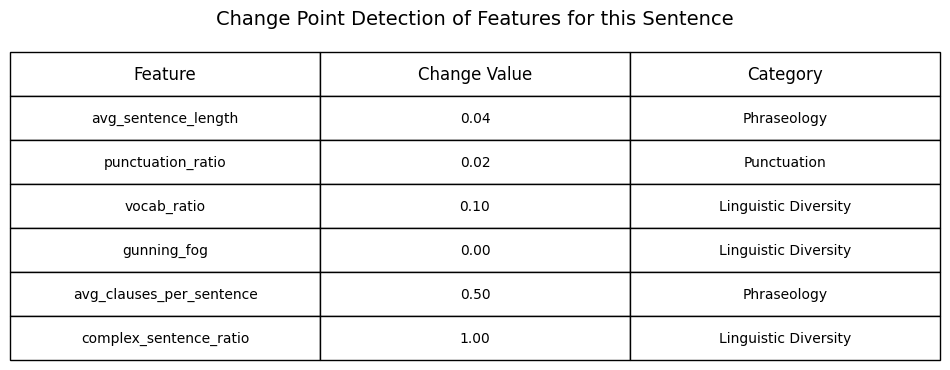

Change detected in sentence: Local government units (LGUs) play a critical role in managing waste at the municipal level.
Feature changes:


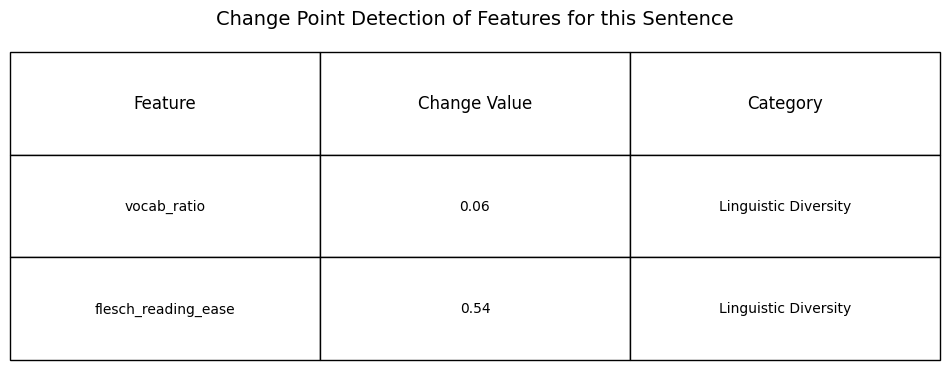

Change detected in sentence: Educational campaigns can help change public attitudes towards plastic use and encourage more sustainable behaviors3.
Feature changes:


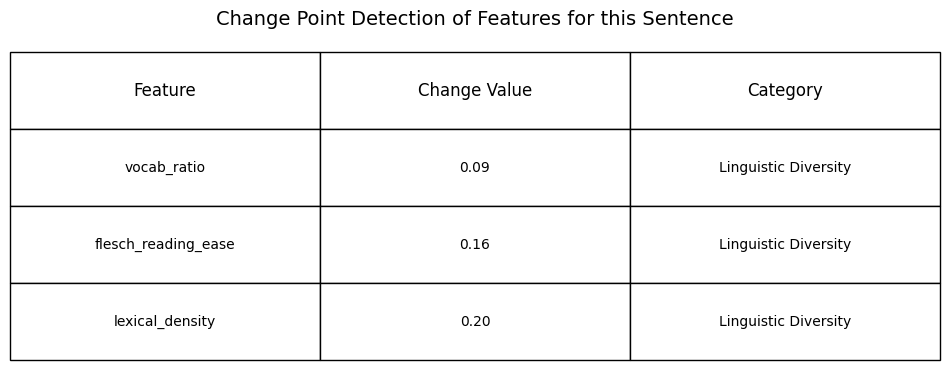

Change detected in sentence: Clean-Up Initiatives: Organizing clean-up drives and community-based waste collection programs can help remove plastic waste from the environment.
Feature changes:


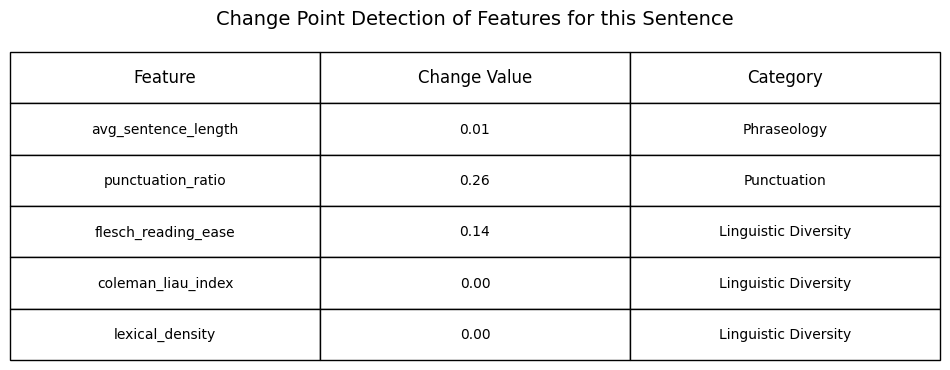

Change detected in sentence: International Collaboration: Addressing plastic pollution requires global cooperation.
Feature changes:


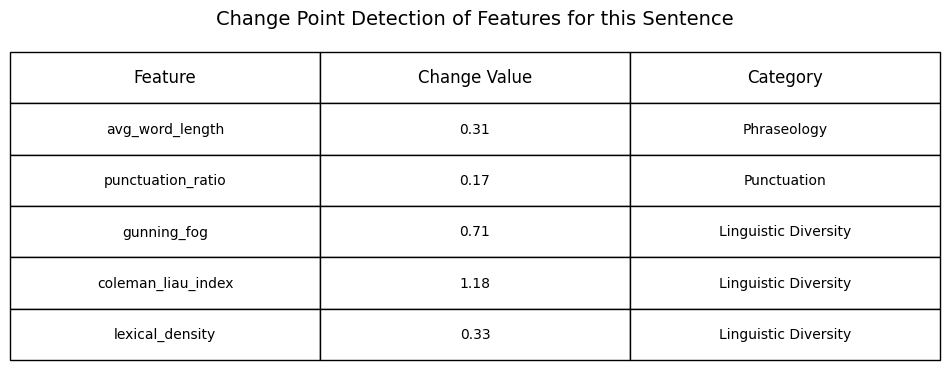

Change detected in sentence: By implementing comprehensive policy reforms, improving waste management infrastructure, promoting a circular economy, and engaging communities, the Philippines can make significant strides in addressing this environmental crisis.
Feature changes:


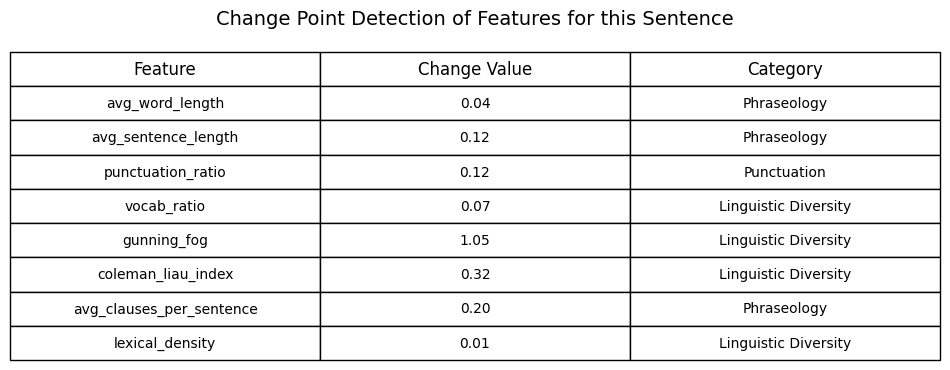


Changepoint Detection DataFrame:


,Sentence Index,Sentence,Feature,Change Value,Category
0,2,"This editorial examines the causes, impacts, a...",avg_word_length,0.035017,Phraseology
1,2,"This editorial examines the causes, impacts, a...",punctuation_ratio,0.063636,Punctuation
2,2,"This editorial examines the causes, impacts, a...",vocab_ratio,0.024242,Linguistic Diversity
3,2,"This editorial examines the causes, impacts, a...",gunning_fog,0.246364,Linguistic Diversity
4,2,"This editorial examines the causes, impacts, a...",coleman_liau_index,0.147500,Linguistic Diversity
...,...,...,...,...,...
97,39,"By implementing comprehensive policy reforms, ...",vocab_ratio,0.066667,Linguistic Diversity
98,39,"By implementing comprehensive policy reforms, ...",gunning_fog,1.049091,Linguistic Diversity
99,39,"By implementing comprehensive policy reforms, ...",coleman_liau_index,0.319167,Linguistic Diversity
100,39,"By implementing comprehensive policy reforms, ...",avg_clauses_per_sentence,0.200000,Phraseology


In [32]:
new_text = """Plastic pollution is a critical environmental issue in the Philippines, posing severe threats to marine ecosystems, public health, and the economy. As one of the world's top contributors to ocean plastic waste, the Philippines faces an urgent need to address this growing crisis. This editorial examines the causes, impacts, and potential solutions to plastic pollution in the Philippines.

The Scale of the Problem
The Philippines generates approximately 2.7 million metric tons of plastic waste annually, with a significant portion ending up in the ocean1. A study by Ocean Conservancy and McKinsey identified the Philippines as the third-largest contributor to ocean plastic pollution globally1. This alarming statistic underscores the magnitude of the problem and the urgent need for effective interventions.

Causes of Plastic Pollution
Several factors contribute to the severe plastic pollution problem in the Philippines:

Single-Use Plastics: The widespread use of single-use plastics, such as sachets, bags, and bottles, is a major contributor to plastic waste. These items are often discarded after a single use, leading to significant environmental pollution2.

Inadequate Waste Management: The country's waste management infrastructure is insufficient to handle the volume of plastic waste generated. Only about 33% of waste is properly managed, with the rest ending up in landfills, rivers, and oceans3. The lack of sanitary landfills and proper waste disposal facilities exacerbates the problem4.

Urban Runoff and Improper Disposal: Urban runoff and improper waste disposal practices contribute to the leakage of plastic waste into waterways. In metropolitan areas like Manila, waste management systems are often overwhelmed, leading to significant plastic pollution3.

Economic and Cultural Factors: The "tingi-tingi" culture, where products are sold in small, disposable packaging, is prevalent due to economic constraints. This practice results in a high volume of plastic waste5.

Impacts of Plastic Pollution
The impacts of plastic pollution in the Philippines are far-reaching and multifaceted:

Environmental Damage: Plastic pollution poses a dire threat to marine ecosystems. Marine animals often mistake plastic debris for food, leading to ingestion, starvation, and death3. Additionally, plastic waste damages coral reefs and mangrove forests, which are critical for coastal protection and marine biodiversity3.

Public Health Risks: The improper disposal of plastics can lead to the leaching of toxic chemicals into the soil and water, posing health risks to communities5. Microplastics, which are small plastic particles, can enter the food chain and potentially impact human health.

Economic Costs: Plastic pollution affects industries such as fishing and tourism, which are vital to the Philippine economy. The presence of plastic waste in coastal areas can lead to reduced fish stocks and a decline in tourism, resulting in economic losses for local communities5.

Social Inequality: Coastal communities, which often rely on fishing and tourism for their livelihoods, are disproportionately affected by plastic pollution. These communities face economic and health challenges due to the presence of plastic waste in their environment3.

Potential Solutions
Addressing plastic pollution in the Philippines requires a comprehensive and multi-faceted approach:

Policy Reforms: Strengthening regulations on single-use plastics and implementing incentives for businesses to adopt sustainable packaging alternatives are crucial steps. The Extended Producer Responsibility (EPR) Act, which holds manufacturers accountable for the entire lifecycle of their products, is a significant policy initiative6. This law requires businesses to manage the waste generated by their products, promoting sustainable practices.

Improving Waste Management: Enhancing waste management infrastructure is essential to reduce plastic pollution. This includes increasing the number of sanitary landfills, improving waste collection systems, and promoting recycling and materials sustainability6. Local government units (LGUs) play a critical role in managing waste at the municipal level.

Promoting a Circular Economy: Transitioning to a circular economy, where products are designed for reuse, recycling, and minimal waste, can significantly reduce plastic pollution7. This approach involves redesigning products and packaging to minimize waste and encouraging the use of biodegradable materials.

Community Engagement and Education: Raising awareness about the impacts of plastic pollution and promoting community involvement in waste management initiatives are vital. Educational campaigns can help change public attitudes towards plastic use and encourage more sustainable behaviors3.

Clean-Up Initiatives: Organizing clean-up drives and community-based waste collection programs can help remove plastic waste from the environment. These initiatives also raise awareness and foster a sense of responsibility among citizens3.

International Collaboration: Addressing plastic pollution requires global cooperation. The Philippines can benefit from sharing best practices and collaborating with other countries and international organizations to develop effective strategies for reducing plastic waste6.

Conclusion
Plastic pollution is a complex and pressing issue that demands immediate and sustained action. By implementing comprehensive policy reforms, improving waste management infrastructure, promoting a circular economy, and engaging communities, the Philippines can make significant strides in addressing this environmental crisis. Ensuring a cleaner and healthier environment is not only essential for the well-being of current and future generations but also crucial for the country's economic and social development. The fight against plastic pollution is a collective responsibility that requires the commitment and cooperation of all sectors of society."""
author = "Copilot"
#thresholds = [0.5, 5, 0.02, 0.05, 5, 2, 1, 2]
# predicted_author = classify_new_text(new_text, clf)

# print(f"The predicted author is: {predicted_author}")
#changepoints, explanations = detect_change_points_in_text(new_text, author, clf)

# Detect changepoints, explanations, and changepoint DataFrame
changepoints, explanations, changepoint_df = detect_change_points_in_text(new_text, author, clf)

# Display options for pandas to prevent compression issues
pd.set_option('display.max_rows', 20)  # Show up to 20 rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust column width

# Display the changepoint DataFrame
print("\nChangepoint Detection DataFrame:")
display(changepoint_df)

# Display the same results as before using explanations
# print("\n--- Detailed Explanations of Changepoints ---")
# for explanation in explanations:
#     print(f"Change detected in sentence: {explanation['sentence']}")
#     print("Feature changes:")
#     for feature_change in explanation['feature_changes']:
#         print(f"  Feature: {feature_change['Feature']}, Change Value: {feature_change['Change Value']:.4f}, Category: {feature_change['Category']}")
#     print("\n" + "-" * 80 + "\n")  # Add a separator line and a blank line

In [33]:
df_results = pd.read_csv('main_dataset_test.csv')
df_results

,index,author,text,ai_label,predicted_label_015,predicted_label_020,predicted_label_015_inv,predicted_author,if_pred_author_correct,if_pred_author_is_ai,overall_change_value
0,1,John Nery,The answers she gave in two Senate hearings we...,0,1,1,0,John Nery,1,0,0.2344
1,2,John Nery,Confusing one with the other allows disinforma...,0,1,0,0,John Nery,1,0,0.1619
2,3,John Nery,The complicated but lasting legacy of Benedict...,0,1,1,0,John Nery,1,0,0.2149
3,4,John Nery,Now that she has passed the point of no return...,0,1,0,0,John Nery,1,0,0.1891
4,5,John Nery,The communist insurgency is at its weakest. Co...,0,1,0,0,Diwa C. Guinigundo,0,0,0.1869
...,...,...,...,...,...,...,...,...,...,...,...
45,46,Copilot,The concept of federalism has been a recurring...,1,1,0,0,Copilot,1,1,0.1728
46,47,Copilot,Election campaign finance transparency is a co...,1,1,0,0,Copilot,1,1,0.1501
47,48,Copilot,Mental health stigma remains a significant bar...,1,0,0,1,Copilot,1,1,0.1485
48,49,Copilot,Urban congestion and housing shortages are two...,1,0,0,1,Copilot,1,1,0.1222


In [34]:
# df_results

# Access columns from the DataFrame
ai_label = df_results['ai_label']
predicted_label_015_inv = df_results['predicted_label_015_inv']
predicted_label_020 = df_results['predicted_label_020']
predicted_label_015 = df_results['predicted_label_015']

# #Model Evaluation
accuracy015inv = accuracy_score(ai_label, predicted_label_015_inv) 
print("\nAccuracy Threshold 0.15 Inverse:", accuracy015inv)
accuracy015 = accuracy_score(ai_label, predicted_label_015) 
print("\nAccuracy Threshold 0.15:", accuracy015)
accuracy020 = accuracy_score(ai_label, predicted_label_020) 
print("\nAccuracy Threshold 0.15:", accuracy020)


conf_matrix015inv = confusion_matrix(ai_label, predicted_label_015_inv)
print("\nConfusion Matrix 0.15 Inverse\n", conf_matrix015inv)
conf_matrix015 = confusion_matrix(ai_label, predicted_label_015)
print("\nConfusion Matrix 0.15\n", conf_matrix015)
conf_matrix020 = confusion_matrix(ai_label, predicted_label_020)
print("\nConfusion Matrix 0.20\n", conf_matrix020)



class_report015inv = classification_report(ai_label, predicted_label_015_inv)
print("\nClassification Report 0.15 Inverse:\n", class_report015inv)
class_report015 = classification_report(ai_label, predicted_label_015)
print("\nClassification Report 0.15:\n", class_report015)
class_report020 = classification_report(ai_label, predicted_label_020)
print("\nClassification Report 0.20:\n", class_report020)




Accuracy Threshold 0.15 Inverse: 0.62

Accuracy Threshold 0.15: 0.38

Accuracy Threshold 0.15: 0.5

Confusion Matrix 0.15 Inverse
 [[19  6]
 [13 12]]

Confusion Matrix 0.15
 [[ 6 19]
 [12 13]]

Confusion Matrix 0.20
 [[18  7]
 [18  7]]

Classification Report 0.15 Inverse:
               precision    recall  f1-score   support

           0       0.59      0.76      0.67        25
           1       0.67      0.48      0.56        25

    accuracy                           0.62        50
   macro avg       0.63      0.62      0.61        50
weighted avg       0.63      0.62      0.61        50


Classification Report 0.15:
               precision    recall  f1-score   support

           0       0.33      0.24      0.28        25
           1       0.41      0.52      0.46        25

    accuracy                           0.38        50
   macro avg       0.37      0.38      0.37        50
weighted avg       0.37      0.38      0.37        50


Classification Report 0.20:
            

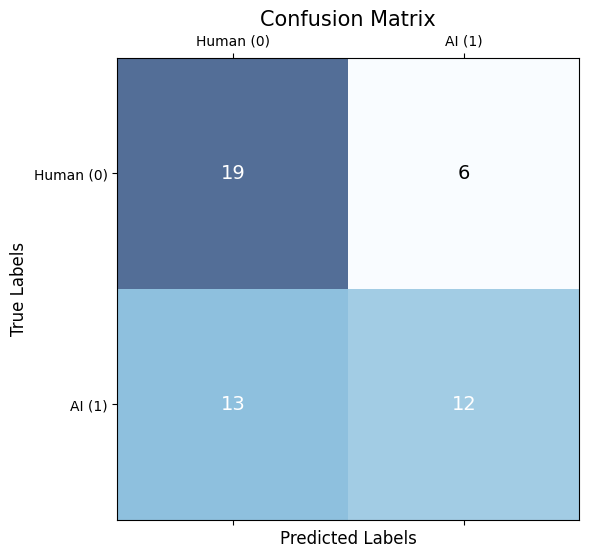

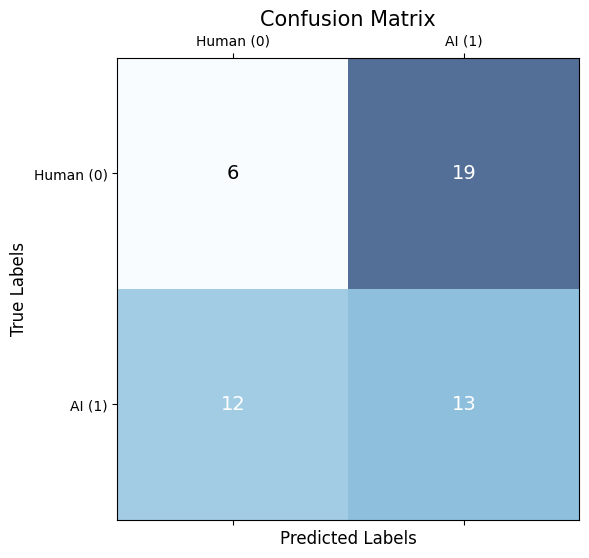

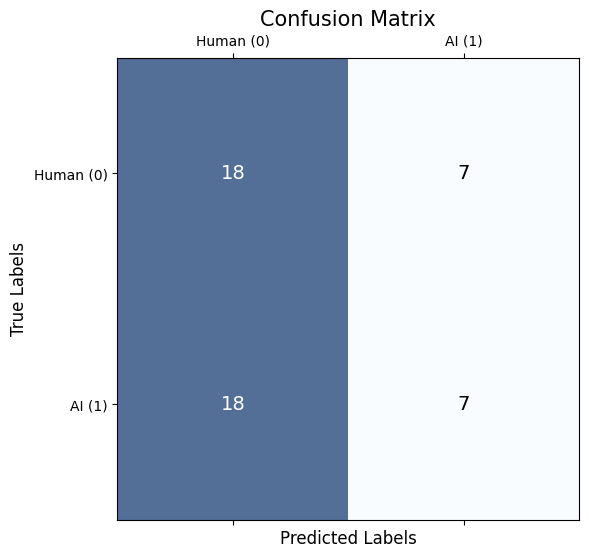

In [35]:
def plot_confusion_matrix(conf_matrix, class_labels):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap="Blues", alpha=0.7)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(
                x=j, y=i, s=conf_matrix[i, j], 
                va='center', ha='center', 
                fontsize=14, color="black" if conf_matrix[i, j] < np.max(conf_matrix) / 2 else "white"
            )

    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.title("Confusion Matrix", fontsize=15)
    plt.show()

# Define the class labels
class_labels = ['Human (0)', 'AI (1)']
plot_confusion_matrix(conf_matrix015inv, class_labels)
plot_confusion_matrix(conf_matrix015, class_labels)
plot_confusion_matrix(conf_matrix020, class_labels)